This is a script to monitor how many valid data points for yesterday's recorded weather are returned by each of our forecasters. The script saves the plot everyt 60 seconds. To find out what time the x axis column corresponds to, use the `what_time` function defined below. This analysis was performed on September 23 for the date of September 22 so if you want to reproduce the results, just set `yesterday_string` variable to `2018-09-22`.

In [38]:
import pandas as pd
import datetime
import time
from matplotlib import pyplot as plt
%matplotlib inline

The first series of while loops and try blocks are there to make sure we are analyzing a csv file that is whole. The current script for ETL of the recorded data updates the csv file continuously so the retreival of its data is messed up while the ETL script saves it.

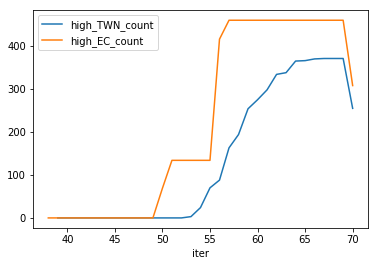

In [39]:
count = 0
while True:
    
    yesterday_string = (datetime.datetime.now().date()-datetime.timedelta(days=1)).strftime('{}-{}-{}'.format('%Y','%m','%d'))
    
    while True:
        try:
            df = pd.read_csv('/Users/Alex/Coding/weather_db/Data/TEST_history_db.csv')
        except pd.errors.EmptyDataError:
            continue
            
        csv_state = (df['date']==yesterday_string).count()
        if csv_state >= count:
            count = csv_state
        else:
            continue

        df = df.set_index(['date','iter','provider'])
        df = df.drop(index='2018-08-19',level=0)

        try:
            df_TWN = df.xs((yesterday_string,'TWN'), level=['date','provider'])
            df_EC = df.xs((yesterday_string,'EC'), level=['date','provider'])
            break
        except KeyError:
                continue
    
    df = df.reset_index()

    TWN_count = df_TWN.groupby('iter').count()
    EC_count = df_EC.groupby('iter').count()

    success_prog = df.join(TWN_count, on='iter',how='outer',rsuffix='_TWN_count')
    success_prog = success_prog.join(EC_count, on='iter',how='outer',rsuffix='_EC_count')

    success_prog = success_prog[['iter','time','high_TWN_count','high_EC_count']].reset_index()

    plot = success_prog.plot(x='iter',y=['high_TWN_count','high_EC_count'])
    fig = plot.get_figure()
    fig.savefig('/Users/Alex/Dropbox (Personal)/{}_history_collection.jpeg'.format(yesterday_string))
    
    # Uncomment the following break if continuous monitoring is required. Otherwise, it will analyze once only.
    #break
    
    time.sleep(60)

Looks like Environment Canada (EC) reached a higher number of reported records than TWN and it also looks like they reached it earlier.

Let's find out when:

In [44]:
def what_time(iter):
    while True:    
        try:
            df = pd.read_csv('/Users/Alex/Coding/weather_db/Data/TEST_history_db.csv')
            break
        except pd.errors.EmptyDataError:
            continue

    return df[(df['date']==yesterday_string)&(df['iter']==iter)][['time']].iloc[1]

Environment Canada was reporting upwards of 450 records around `iter` 56, which occured at:

In [45]:
what_time(56)

time    08:27:32.845741
Name: 132000, dtype: object

Meanwhile, The Weather Network never even reached 400 records and they peaked later, at `iter` 64, which occured at:

In [46]:
what_time(64)

time    13:05:37.619512
Name: 141472, dtype: object